# Slope Deflection Example - Frame 1
Illustrates the solution of simple, statically-indeterminate framed structures
using the method of **slope-deflection** and symbolic algebra.
This version uses an improved version of 'sdutil' that computes end shears as well as moments.

In [1]:
from sympy import *                 # use symbolic algebra
init_printing(use_latex='mathjax')  # print nice math (use_latex arg is workaround for FormatterWarning messages)

In [2]:
from sdutil2 import SD, FEF

Analyze the following frame using the method of **slope-deflection**.

![Frame](frame1.svg)

This frame has 5 independant joint displacements - rotations at the four
joints *a*, *b*, *c*, and *d*, and a lateral displacement of joints *b*
and *c* together.  Actually, we know that joint *d* does not rotate, but we
will pretend it does for now, and will handle that as a displacement constraint
later.

So now we write the slope deflection equations.  These express the end moments
as functions of the five unknown displacements.  Note also that we do not treat the
pin-ended member *ab* specially -- it is not necessary to do so.

We use a very simple utility function *SD()* to compute the end moments and shears of a segment,
as a function of the end displacements:

In [4]:
help(SD)

Help on function SD in module sdutil2:

SD(L, EI, t0, t1, d01=0)
    Return the end moments and shears of a segment as computed by the slope 
    deflection equations.
       L = length, 
       EI = stiffness, 
       t0 = rotation at end 0 (left), 
       t1 = rotation at end 1, 
       d01 = relative lateral displacment end 0 to end 1.  
    SD sign convention: moments and rotation are +ive CW, 
    relative displacement d01 is +ive for CW rotation of chord.



In [5]:
# Slope deflection equations:
# theta_a,b,c,d - rotations of joints
# Delta_ab - horizontal displacement of joint b (and c) relative to a (and d)
var('EI theta_a theta_b theta_c theta_d Delta_ab')
Mab,Mba,Vab,Vba = SD(3,EI,theta_a,theta_b,Delta_ab)
Mbc,Mcb,Vbc,Vcb = SD(6,2*EI,theta_b,theta_c,0) + FEF.udl(6,36)
Mcd,Mdc,Vcd,Vdc = SD(2,EI,theta_c,theta_d,Delta_ab)

Display just one of the end moments to see what the values look like.  They are indeed algebraic expressions.

In [6]:
Mbc

EI⋅(4⋅θ_b + 2⋅θ_c)      
────────────────── - 108
        3               

Now we write five linear equations to solve for the five unknown displacements.
Three are equilibrium equations and involve moments at three of the joints: $Mab = 0$, $Mba+Mbc=0$, and $Mcb+Mcd=0$.
One equation involves the equilibrium of the column shears with the horizontal applied
load: $Vab+Vdc-60=0$.  The fifth equation is just the known rotation at joint *d*: $\theta_d=0$.

In sympy, we build a list of the five equations, all expressed as $f(..,..) = 0$ and giving only the left side of each (the right side always being 0 is not given).  We then call the solver and give it a list of variables to solve for:

In [7]:
eqns = [Mab, Mba+Mbc, Mcb+Mcd, Vab+Vdc-60, theta_d]
soln = solve(eqns,[theta_a,theta_b,theta_c,theta_d,Delta_ab])
soln

⎧       3528       -426        14604        -9336         ⎫
⎨Δ_ab: ──────, θₐ: ─────, θ_b: ──────, θ_c: ──────, θ_d: 0⎬
⎩      247⋅EI      19⋅EI       247⋅EI       247⋅EI        ⎭

The above solution is returned as a Python dictionary, making it easy to substitute for those
variables in other equations.

In fact, that is done now, substituting the displacement solutions into each
of the slope-deflection equations.  The result is a list of the member end moments (and shears).

The '.n(4)' method forces a numerical answer with 4 significant figures.

In [8]:
{v:eval(v).subs(soln).n(4) for v in 'Mab,Mba,Mbc,Mcb,Mcd,Mdc,Vab,Vdc'.split(',')}

{'Mab': 0,
 'Mba': 54.36,
 'Mbc': -54.36,
 'Mcb': 97.02,
 'Mcd': -97.02,
 'Mdc': -59.22,
 'Vab': -18.12,
 'Vdc': 78.12}

And now - the reactions at supports *a* and *d*:

In [9]:
Ra = Vbc
Rd = -Vcb
Ha = -Vab
Hd = -Vdc
Md = Mdc
[v.subs(soln).n(4) for v in [Ra,Ha,Rd,Hd,Md]]

[100.9, 18.12, 115.1, -78.12, -59.22]

#### Equilibrium checks:

In [10]:
# sum horizontal forces
(Ha + Hd + 60).subs(soln)

0

In [11]:
# sum vertical forces
(Ra + Rd - 36*6).subs(soln)

0

In [12]:
# sum moments about a
(60*3 + 36*6*3 + Hd*1 + Md - Rd*6).subs(soln)

0

### Plots
Plot bending moment in *bc* as a function of distance *x* from left end, *b*:

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

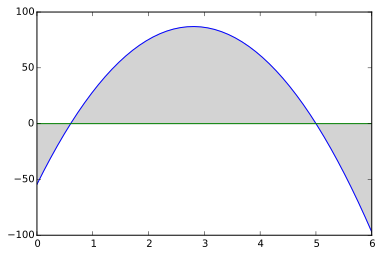

In [14]:
var('x')
Mbcx = (Ra*x + Vab*3 - 36*x*x/2).subs(soln)  # M as a function of x
fn = lambdify((x),Mbcx)   # convert moment expression to a function of one argument
z = np.linspace(0,6)
plt.plot(z,fn(z),[0,6],[0,0])
plt.fill_between(z,fn(z),color='lightgrey')
##plt.show()

Find the locations along span *bc* of zero moment:

In [15]:
[r.n(4) for r in solve(Mbcx)]

[0.6039, 5.001]

Find point of maximum moment and the maximum moment in the span:

In [16]:
xs = solve([Mbcx.diff(x)])
xs

⎧   6230⎫
⎨x: ────⎬
⎩   2223⎭

In [17]:
xs[x].n(4), Mbcx.subs(xs).n(4)

(2.803, 87.01)